# 95-865 Homework 3

Your name: Zhexin Chen

Your Andrew ID: zhexinc

Collaborators (if none, say \"none\"; do *not* leave this blank): None

# Part 1: Email spam classification [50 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

### (a) Print the number of ham and spam emails [1 point]
 
In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it?

In [62]:
#your code here
import glob
ham_files = glob.glob('./email-data/ham/*.txt')
spam_files = glob.glob('./email-data/spam/*.txt')
test_files = glob.glob('./email-data/testing/*.txt')


print(len(ham_files))
print(len(spam_files))

1500
3671


### (b) Construct the documents [4 points]
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [2]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [3]:
#your code here
label=[]
documents=[]

for file in ham_files[:100]:
    documents.append(makeWordList(file))
    label.append(0)
    
for file in spam_files[:100]:
    documents.append(makeWordList(file))
    label.append(1)
doc_label=np.array(label)

### (c) Construct the document matrix `X` as a matrix of word frequencies [5 points]

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [5]:
#your code here
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=0.8,
                                min_df=50,
                                stop_words='english')
tf = vectorizer.fit_transform(documents)
print(vectorizer.vocabulary_)

### (d) k-NN, SVM, random forest: Hyperparameter selection [20 points]

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - SVM: (SVC) Select `C` from a range of your choice, use any kernel that performs well.
   - Random forest: Select `n_estimators` **and** `max_depth` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_C`, `best_n_estimators`, and `best_max_depth` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [49]:
import warnings
from sklearn import svm
from sklearn.model_selection import KFold
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

warnings.simplefilter('ignore')

num_folds = 5
k_fold = KFold(num_folds)
hyperparameter_settings = [k for k in range(1,51)]  # fill this with hyperparameter settings that you want to try

indices=range(tf.shape[0])
best_k = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
for hyperparam_setting in hyperparameter_settings:
    fold_scores = []
    # your code to train and score the training data here
    for train_indices, val_indices in k_fold.split(indices):
        classifier = KNeighborsClassifier(n_neighbors=hyperparam_setting)
        classifier.fit(tf[train_indices],
                       doc_label[train_indices])
        predicted_val_labels = classifier.predict(tf[val_indices])
        pred_score=f1_score(doc_label[val_indices],predicted_val_labels,average='weighted')
        fold_scores.append(pred_score)
    
    cross_val_score = np.mean(fold_scores)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_k = hyperparam_setting

print('Best k for KNN:', best_k)

Best k for KNN: 3


In [56]:
from sklearn.svm import SVC

num_folds = 5
k_fold = KFold(num_folds)
hyperparameter_settings = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]  # fill this with hyperparameter settings that you want to try

indices=range(tf.shape[0])
best_C = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
for hyperparam_setting in hyperparameter_settings:
    fold_scores = []
    # your code to train and score the training data here
    for train_indices, val_indices in k_fold.split(indices):
        classifier = SVC(C=hyperparam_setting)
        classifier.fit(tf[train_indices],
                       doc_label[train_indices])
        predicted_val_labels = classifier.predict(tf[val_indices])
        pred_score=f1_score(doc_label[val_indices],predicted_val_labels,average='weighted')
        fold_scores.append(pred_score)
    
    cross_val_score = np.mean(fold_scores)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_C = hyperparam_setting

print('Best C for SVC:', best_C)

Best C for SVC: 10


In [57]:
from sklearn.ensemble import RandomForestClassifier
num_folds = 5
k_fold = KFold(num_folds)
hyperparameter_settings = [(num_trees, max_depth)
                           for num_trees in [50, 100, 150, 200]
                           for max_depth in [3, 4, 5, None]]  # fill this with hyperparameter settings that you want to try

best_n_estimators = None
best_max_depth = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
for hyperparam_setting in hyperparameter_settings:
    num_trees, max_depth = hyperparam_setting
    fold_scores = []
    # your code to train and score the training data here
    for train_indices, val_indices in k_fold.split(indices):
        classifier = RandomForestClassifier(n_estimators=num_trees,
                                            max_depth=max_depth)
        classifier.fit(tf[train_indices],
                       doc_label[train_indices])
        predicted_val_labels = classifier.predict(tf[val_indices])
        pred_score=f1_score(doc_label[val_indices],predicted_val_labels,average='weighted')
        fold_scores.append(pred_score)
        
    cross_val_score = np.mean(fold_scores)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_n_estimators = hyperparam_setting[0]
        best_max_depth = hyperparam_setting[1]

print('Best number of trees and max depth for Random Forest:', best_n_estimators, best_max_depth)

Best number of trees and max depth for Random Forest: 100 None


### (e) Classifier testing: Precision-Recall and ROC curves [20 points]

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the training data.
   - Use test emails to in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 3 ROC curves, one for each classifier.
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 3 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

Answer: My approach to address the problem that words in testing dataset are not present in the training set is to combine training and testing dataset together before getting the word frequencies, and get a word frequency matrix for all data. Then I split the matrix into train and test matrix accordingly.

In [82]:
#your code here
import matplotlib.pyplot as plt
new_vectorizer = CountVectorizer(max_df=0.8,
                                min_df=50,
                                stop_words='english')

all_label=[]
all_documents=[]

for file in ham_files[:100]:
    all_documents.append(makeWordList(file))
    all_label.append(0)
    
for file in spam_files[:100]:
    all_documents.append(makeWordList(file))
    all_label.append(1)
    
for file in test_files[:100]:
    all_documents.append(makeWordList(file))
    if file[-7:-4]=='ham':
        all_label.append(0)
    if file[-7:-4]=='pam':
        all_label.append(1)

all_label=np.array(all_label)

In [76]:
# new_tf = new_vectorizer.fit_transform(all_documents)
# train_tf=new_tf[:(len(ham_files)+len(spam_files))]
# test_tf=new_tf[(len(ham_files)+len(spam_files)):]
# train_label=all_label[:(len(ham_files)+len(spam_files))]
# test_label=all_label[(len(ham_files)+len(spam_files)):]

In [80]:
new_tf = new_vectorizer.fit_transform(all_documents)
train_tf=new_tf[:200]
test_tf=new_tf[200:]
train_label=all_label[:200]
test_label=all_label[200:]

In [85]:
clf_knn=KNeighborsClassifier(n_neighbors=best_k)
clf_knn.fit(train_tf,train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [84]:
clf_rf=RandomForestClassifier(n_estimators=best_n_estimators,
                                            max_depth=best_max_depth)
clf_rf.fit(train_tf,train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [95]:
clf_svm=SVC(C=best_C)
clf_svm.fit(train_tf,train_label)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Text(0, 0.5, 'TPR')

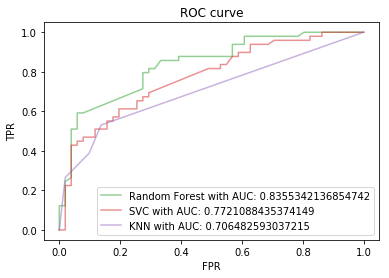

In [101]:
from sklearn.metrics import roc_curve

colors = ['C2','C3', 'C4']

y_score_rf = clf_rf.predict_proba(test_tf)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_label, y_score_rf, pos_label=1)
auc_rf = np.trapz(tpr_rf, fpr_rf)
label_rf='Random Forest with AUC: '+str(auc_rf)
plt.plot(fpr_rf, tpr_rf, linestyle='-', alpha=0.5, color= colors[0], label = label_rf)

y_score_svm = clf_svm.decision_function(test_tf)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(test_label, y_score_svm, pos_label=1)
auc_svm = np.trapz(tpr_svm, fpr_svm)
label_svm='SVC with AUC: '+str(auc_svm)
plt.plot(fpr_svm, tpr_svm, linestyle='-', alpha=0.5, color= colors[1], label = label_svm)

y_score_knn = clf_knn.predict_proba(test_tf)[:,1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(test_label, y_score_knn, pos_label=1)
auc_knn = np.trapz(tpr_knn, fpr_knn)
label_knn='KNN with AUC: '+str(auc_knn)
plt.plot(fpr_knn, tpr_knn, linestyle='-', alpha=0.5, color= colors[2], label = label_knn)

plt.legend( loc = 'best')   
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")

Text(0.5, 1.0, 'Precision-Recall curve')

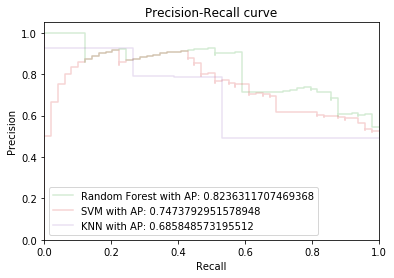

In [111]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

average_precision_rf = average_precision_score(test_label, y_score_rf)
precision_rf, recall_rf, _ = precision_recall_curve(test_label, y_score_rf)
label_rf='Random Forest with AP: '+str(average_precision_rf)
plt.step(recall, precision, color=colors[0], alpha=0.2,
         where='post',label=label_rf)

average_precision_svm = average_precision_score(test_label, y_score_svm)
precision_svm, recall_svm, _ = precision_recall_curve(test_label, y_score_svm)
label_svm='SVM with AP: '+str(average_precision_svm)
plt.step(recall_svm, precision_svm, color=colors[1], alpha=0.2,
         where='post',label=label_svm)

average_precision_knn = average_precision_score(test_label, y_score_knn)
precision_knn, recall_knn, _ = precision_recall_curve(test_label, y_score_knn)
label_knn='KNN with AP: '+str(average_precision_knn)
plt.step(recall_knn, precision_knn, color=colors[2], alpha=0.2,
         where='post',label=label_knn)

plt.legend( loc = 'best')   
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')

Answer: 

My approach to address the problem that words in testing dataset are not present in the training set is to combine training and testing dataset together before getting the word frequencies, and get a word frequency matrix for all data. Then I split the matrix into train and test matrix accordingly.

Of the two curves I would choose Precision-Recall curve, because our dataset is not very balanced between spam and ham e-mails and Precision-Recall curve is more applicable in this case.

Using the Precision-Recall curve, Random Forest is a better classifier in our case.

# Part 2: Image Segmentation [50 points]

### What is segmentation?

Segmentation is the task of "labeling" groups of pixels in an image to identify certain objects.

In the early years, research on segmentation was focused on "foreground-background" segmentation; marking only those pixels that comprise the "background" of an image (in the image below, the background is marked in blue).

<div>
<img src="http://www.eyeshalfclosed.com/images/cat.jpg" width=500/>
</div>

In recent years, sophisticated deep-learning models have enabled complex multi-label segmentation, such as in the images below.

<tr>
<td>
<img src="http://www.eyeshalfclosed.com/images/sheep.png" width=500/>
</td>
<td>
<img src="http://www.eyeshalfclosed.com/images/street.png" width=500/>
</td>
</tr>
   

### (a) Prerequisites [20 points]

You get 20 points for setting up AWS and successfully running the code given in the following sections.

This homework needs to be run on an AWS GPU instance; it will not complete in time without a GPU. Look up the relevant documentation to set up an AWS machine as configured below.

**Machine.**

   - Use the [Ubuntu Deep Learning AMI](https://aws.amazon.com/marketplace/pp/B077GCH38C).
   - Use a p2.xlarge instance.
   - Allocate at least 80GB of disk space.
   - Use the `conda_tensorflow_p36` Conda environment: `source activate tensorflow_p36`
   - Create a security group and open all inbound/outbound ports to 0.0.0.0/0.

All commands below assume the aforementioned Conda environment is active.

**Run Jupyter.** `jupyter notebook --ip=* --no-browser`

You may move Jupyter to the background by: CTRL-Z, then `bg`, then `disown`. You can access Jupyter using your public DNS; it will look something like `ec2-54-84-36-171.compute-1.amazonaws.com:8888`. Figure out how you can find this out.

**Data downloads.** All downloads must go into the same directory as this notebook. Unzip files after download. *This will take time.*

   * Download the [trained model weights](https://github.com/matterport/Mask_RCNN/releases/download/v1.0/mask_rcnn_coco.h5) (~250MB).

   * Download the [training images](http://images.cocodataset.org/zips/train2014.zip) (13GB).
   
   * Download the [validation images](http://images.cocodataset.org/zips/val2014.zip) (6GB).
   * Download the [training image annotations](https://dl.dropboxusercontent.com/s/o43o90bna78omob/instances_minival2014.json.zip?dl=0).
   * Download the [test image annotations](https://dl.dropboxusercontent.com/s/s3tw5zcg7395368/instances_valminusminival2014.json.zip?dl=0).

Now create a new folder named `2014`, then move the `train2014`, `val2014` folders into `2014/`.

Create a new `2014/annotations/` folder and move the train and test annotation JSON files into it

Your directory structure should look like:
```
2014/
   /annotations/
       /annotations/instances_minival2014.json
       /annotations/instances_valminusminival2014.json
   /train2014/
       /train2014/*.jpg
   /val2014/
       /val2014/*.jpg
```

**Package installation.**

   * Install Cython: `pip install cython`
   * Install Tensorflow: `pip install tensorflow tensorflow-gpu`
   * Install Keras and image tools: `pip install keras scikit-image pillow h5py`
   * Install OpenCV: `pip install opencv-python`
   * Install pycoco:
   
`pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"`
   
**GPU.** Ensure Keras/TensorFlow can see your GPU with the following Python code (run in the `conda_tensorflow_p36 environment` after installing all the required packages). You should see a GPU in one of the devices listed.

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

### Testing a pre-trained model on small data

We will first load a pre-trained convolutional neural network model and test it on a small dataset of images. These images are stored in the `/images/` folder.

The model was trained by annotating each image with the objects it contains. Annotations are in the following format:

```
annotation{
    "id" : int,
    "image_id" : int,
    "category_id" : int,
    "segmentation" : RLE or [polygon],
    "area" : float,
    "bbox" : [x,y,width,height],
    "iscrowd" : 0 or 1,
}

categories[{
    "id" : int,
    "name" : str,
    "supercategory" : str,
}]
```

Make sure you understand the annotations and how they are connect to images by looking at [section 4 on this page](http://cocodataset.org/#download). You may ignore the `iscrowd` variable.

### Set up the environment

In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
from model import log
import visualize
from config import Config
from shapes import ShapesDataset

from pycocotools.coco import COCO

%matplotlib inline 

ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

### Model configuration

These lines specify how many GPUs to use, and how many images to process in parallel on each GPU.

In [ ]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

### Load the pre-trained model

This is actually a Keras model wrapped along with some helpful functions. The model may be loaded in two modes: `training` and `inference` (testing) mode. `model_dir` points towards a directory to save logs and trained weights, which we have set above as the `/logs` directory.

In [ ]:
%%time
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)

### Hard-code object classes

For the small dataset of images we are using, we define our own list of class names and class indices for each object. These are of various types: for example, "car", "bicycle", etc..

In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

### Load and visualize a random image

Make sure you understand what the code below is doing.

In [ ]:
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
plt.imshow(image)
plt.show()

### Test the pre-trained model

We now call the `detect` function of the model on the list of images we want to be segmented. This returns a `result` object; inspect this object to see what it contains.

The `visualize` helper module provides useful functions to visualize our segmentation results. Understand how this function works (SHIFT+TAB in Jupyter is useful, as well as looking at the code in `visualize.py` directly).

In [ ]:
%%time
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

### Training from scratch

Now that we understand what a properly trained model should do, we consider training a model from scratch.

### Load the data

Load the annotations for the training images into memory.

In [ ]:
%%time
config = coco.CocoConfig()
COCO_DIR = "2014"
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "minival")
dataset.prepare()

Now load the same for the test images.

In [ ]:
%%time
dataset_val = coco.CocoDataset()
dataset_val.load_coco(COCO_DIR, "val35k")
dataset_val.prepare()

### List a few object classes

In [ ]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    if i > 10:
        break

### Visualize a random image and its annotations

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### Training configuration

See the default configuration values in `config.py`.

In [ ]:
class TrainConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 60

config = TrainConfig()
config.display()

### (b) Create a new model in training mode [5 points]

In [ ]:
# your code here

### (c) Initialize the model weights with the weights learned on COCO [5 points]

Call `load_weights` as before, but add the following argument in the call to the function:

```
exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
          "mrcnn_bbox", "mrcnn_mask"]
```

In [ ]:
# your code here

### (d) Train the model for 10 epochs [5 points]

Look up the documentation or code for the train function to figure out its arguments.

Pass the following additional arguments to the `train` function:

   - `layers="heads"` to only train the weights that were not pre-loaded.
   - `learning_rate=config.LEARNING_RATE` to set the learning rate.
   - `epochs=10`.
   
This will take ~10 minutes on a p2.xlarge GPU instance with 1 GPU.

In [ ]:
%%time
# call to train

### (e) Visualize learning progress with TensorBoard [5 points]

   - Start Tensorboard (in a terminal) with `tensorboard --logdir=logs/` in the same folder as the notebook:
```
TensorBoard 0.1.8 at http://ip-172-31-27-18:6006 (Press CTRL+C to quit)
```

   - Connect to (in a web browser) `public_dns:6006` where `public_dns` is your public DNS (this is the address of your AWS machine).
   - Click on the "Scalars" tab at the top of the page.
   - Include a screenshot of the overall loss vs. number of epochs below this line (store the image in the same folder as the notebook as "yourloss.png"). **Important: When you submit your HW3, it should include `yourloss.png`.**
   
 <img src="yourloss.png"/>

### (f) Test model [10 points]

Load the model in inference (testing) mode.

In [ ]:
# load model

Load the last trained model weights.

In [ ]:
model_path = model.find_last()[1] # use the last trained weights
model.load_weights(model_path, by_name=True)

Visualize the true annotations of a random test image.

In [ ]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

Visualize the predicted annotations for this image

In [ ]:
# prediction function call and visualization

# Part 3: Sentiment Analysis [50 points]

Download data from: http://www.andrew.cmu.edu/user/georgech/HW3-data.zip <br>

The folder contains:

- train.csv
- test.csv

### (a) Read the training data  [5 Points]

Read the data present in train.csv file. **Please do no change the file name. In particular, use a relative path, i.e., './HW3-data/train.csv'** <br>
Perform the following cleaning on the data:
1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Shuffle the rows of the data frame such that the positive and negative tweets are mixed
3. Print the first 5 sentiments.
4. Print the number of positive and negative sentiment labels
Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [6]:
# your code here
import pandas as pd

train=pd.read_csv('./HW3-data/train.csv',encoding='iso8859',header=None)

In [10]:
train_data=train.iloc[:,[0,5]]

In [12]:
train_data.head()

,0,5
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [26]:
train_data=train_data.sample(frac=1).reset_index(drop=True)

In [46]:
print('First five sentiments')
print(train_data.iloc[:5,0])

First five sentiments
0    0
1    0
2    0
3    0
4    1
Name: 0, dtype: int64


### (b) Data Preparation [7 points]

Before building a neural network model, we first need to prepare the data. The input to a RNN model  is a matrix with shape (a, b), where a is the number of samples (tweets), and b is the sequence length of each tweet. Prepare the data with the following steps:

1\. Take the RAW texts of the top 5000 tweets in the data and convert them to a list of strings, where each string is a tweet. [1 pt]

In [50]:
# your code here
string_list=train_data.iloc[:5000,1].tolist()
label_list=train_data.iloc[:5000,0].tolist()

2\. Use `Tokenizer` from `keras.preprocessing.text` to tokenize the texts and convert them to sequences (numbers) with the `texts_to_sequences` method of `Tokenizer`. **When tokenizing, please only consider the top 10,000 words in the dataset (`num_words`=10,000)**. [4 pts]

In [55]:
# your code here
from keras.preprocessing.text import Tokenizer
tk=Tokenizer(num_words=10000)
tk.fit_on_texts(string_list)
freq_list=tk.texts_to_sequences(string_list)

3\. Use `pad_sequences` from `keras.preprocessing.sequence` to pad each sequence with zeros to **make the sequence length 120**. [2 pts]

In [57]:
# your code here
from keras.preprocessing.sequence import pad_sequences
freq_list = pad_sequences(freq_list, maxlen=120)

###  (c) Simple RNN [20 points]

i) [8 points] Build a simple RNN model with the following specification:
1. An embedding layer with output dimenstion 64.
2. A simple RNN layer.
3. A dense layer with sigmoid activation function for prediction.
Print the summary of the model.

In [60]:
# your code here
from keras.models import Sequential
from keras.layers import Embedding, RNN, Dense, SimpleRNN

rnn = Sequential()
rnn.add(Embedding(10000, 64, input_length=120))
rnn.add(SimpleRNN(120))
rnn.add(Dense(1, activation='sigmoid'))
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 120)               22200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 121       
Total params: 662,321
Trainable params: 662,321
Non-trainable params: 0
_________________________________________________________________


ii) [12 points] Now train the simple RNN model:

1\. Compile the model with binary cross entory as loss and accuracy as evaluation metrics.

In [63]:
# your code here
from keras.optimizers import RMSprop
rmsprop=RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
rnn.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics=['acc'])

2\. Fit the model with the training set with 5 epochs (use 20% of the data as validation). Play with the batch size to find a value that seems to work well (for example, you may find a smaller choice like 32 to result in extremely slow learning; try larger values like 512, 1024, etc).

In [64]:
label_list=train_data.iloc[:5000,0].tolist()

In [65]:
# your code here
rnn_fit = rnn.fit(freq_list, label_list, validation_split=0.2, epochs=5, batch_size=1024)

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 6s 2ms/step - loss: 0.7011 - acc: 0.5135 - val_loss: 0.7218 - val_acc: 0.5110
Epoch 2/5
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6797 - acc: 0.5767 - val_loss: 0.6890 - val_acc: 0.5340
Epoch 3/5
4000/4000 [==============================] - 7s 2ms/step - loss: 0.6433 - acc: 0.7700 - val_loss: 0.6870 - val_acc: 0.5430
Epoch 4/5
4000/4000 [==============================] - 9s 2ms/step - loss: 0.5860 - acc: 0.8653 - val_loss: 0.6870 - val_acc: 0.5420
Epoch 5/5
4000/4000 [==============================] - 9s 2ms/step - loss: 0.5240 - acc: 0.8927 - val_loss: 0.6910 - val_acc: 0.5390


3\. Plot the training and validation accuracy across epochs.

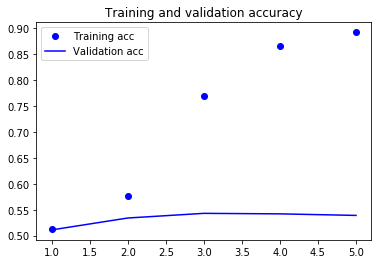

In [68]:
# your code here
import matplotlib.pyplot as plt
acc = rnn_fit.history['acc']
val_acc = rnn_fit.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### (d) LSTM [4 points] 

i) [2 point] Now built a LSTM model by replacing the simple RNN layter in the above model with a LSTM layer. Print a summary of the LSTM model.

In [69]:
# your code here
from keras.layers import LSTM
lstm = Sequential()
lstm.add(Embedding(10000, 64, input_length=120))
lstm.add(LSTM(120))
lstm.add(Dense(1, activation='sigmoid'))
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               88800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 121       
Total params: 728,921
Trainable params: 728,921
Non-trainable params: 0
_________________________________________________________________


ii) [2 point] Train the LSTM model with the same specifications in the simple RNN model. Again, plot the training and validation accuracy across epochs.

In [70]:
# your code here
lstm.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics=['acc'])
lstm_fit = lstm.fit(freq_list, label_list, validation_split=0.2, epochs=5, batch_size=1024)

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 37s 9ms/step - loss: 0.6916 - acc: 0.5287 - val_loss: 0.6864 - val_acc: 0.5570
Epoch 2/5
4000/4000 [==============================] - 29s 7ms/step - loss: 0.6709 - acc: 0.6053 - val_loss: 0.6687 - val_acc: 0.6280
Epoch 3/5
4000/4000 [==============================] - 38s 10ms/step - loss: 0.6233 - acc: 0.6752 - val_loss: 0.6518 - val_acc: 0.5980
Epoch 4/5
4000/4000 [==============================] - 36s 9ms/step - loss: 0.5541 - acc: 0.7410 - val_loss: 0.6227 - val_acc: 0.6770
Epoch 5/5
4000/4000 [==============================] - 31s 8ms/step - loss: 2.6744 - acc: 0.6980 - val_loss: 0.6120 - val_acc: 0.6790


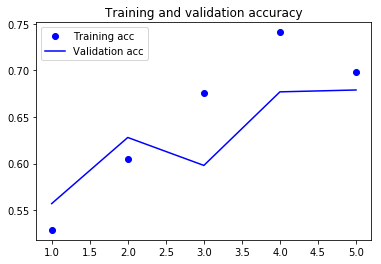

In [71]:
acc = lstm_fit.history['acc']
val_acc = lstm_fit.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### (e) Evaluation on test data [14 points]

i) [5 points] Using the simple RNN and LSTM models from the previous parts (do *not* retrain these using the full training dataset; it's fine to use the same models you learned from before where technically 20% of the training data were held out as validation data), evaluate their performance on the *test* set (`test.csv`). What are the test set raw accuracies that you get?

In [89]:
# your code here
test=pd.read_csv('./HW3-data/test.csv',encoding='iso8859',header=None)

In [90]:
test_x = test.iloc[:,5].tolist()
test_y = test.iloc[:,0].tolist()
tk=Tokenizer(num_words=10000)
tk.fit_on_texts(test_x)
test_x=tk.texts_to_sequences(test_x)
test_x = pad_sequences(test_x, maxlen=120)
test_x = pad_sequences(test_x, maxlen=120)
rnn_eval=rnn.evaluate(test_x,test_y)
lstm_eval=lstm.evaluate(test_x,test_y)
print('Accuracy for RNN:',"{:.2f}".format(rnn_eval[1]),'\nAccuracy for LSTM',"{:.2f}".format(lstm_eval[1]))

498/498 [==============================] - 1s 2ms/step
Accuracy for RNN: 0.58 
Accuracy for LSTM 0.45


ii) [9 points] In the previous models, we only use the top 5000 tweets. Now train the LSTM-based model using the whole training dataset. Again use 20% of the training dataset as validation. After learning the model, test it on the true test set. What is the test set raw accuracy that you get? How does this test set accuracy compare to the validation accuracy, and to the test set accuracy you got from using only 5000 tweets (or technically 5000\*0.8=4000 tweets to train)?

In [92]:
# your code here
train=pd.read_csv('./HW3-data/train.csv',encoding='iso8859',header=None)
train_x = train.iloc[:,5].tolist()
train_y = train.iloc[:,0].tolist()


In [94]:
tk=Tokenizer(num_words=10000)
tk.fit_on_texts(train_x)
train_x=tk.texts_to_sequences(train_x)
test_x = test.iloc[:,5].tolist()
test_x=tk.texts_to_sequences(test_x)


In [95]:
train_x = pad_sequences(train_x, maxlen=120)
test_x = pad_sequences(test_x, maxlen=120)

In [96]:
lstm_new = Sequential()
lstm_new.add(Embedding(10000, 64, input_length=120))
lstm_new.add(LSTM(120))
lstm_new.add(Dense(1, activation='sigmoid'))
lstm_new.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 64)           640000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 120)               88800     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 121       
Total params: 728,921
Trainable params: 728,921
Non-trainable params: 0
_________________________________________________________________


In [97]:
lstm_new.compile(optimizer=rmsprop,loss='binary_crossentropy',metrics=['acc'])
lstm_new_fit = lstm_new.fit(train_x, train_y, validation_split=0.2, epochs=5, batch_size=1024)

Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
 131072/1280000 [==>...........................] - ETA: 2:05:10 - loss: 0.5187 - acc: 0.7463

KeyboardInterrupt: 

In [ ]:
lstm_new_eval=lstm_new.evaluate(test_x,test_y)
print('Test accuracy on the full set:',"{:.2f}".format(lstm_new_eval[1]))

The test accuracy is lower than the validation accuracy, and the test accuracy of the model trained on the full dataset is better than the accuracy of the model trained on the 5000-datapoint dataset, that is because the model on the full set is more likely to capture the generalized information for this specific question.